In [1]:
import os
import time
import numpy as np
from astropy.modeling import models, fitting
from astropy.table import Table
import matplotlib.pyplot as plt
from scipy import stats
from skimage.transform import resize
from photutils import CircularAperture, CircularAnnulus
from usid_processing import parallel_compute
from functools import partial

import galsim

from utils import *
from model import *

############################################
# Setup
############################################

# Fitting Parameter
n_cpu = 3
RUN_FITTING = True
draw = True
mask_strip = True
mask_dual = True
wid_strip, n_strip = 5, 10
dir_name = "./real"

############################################
# Read
############################################

hdu = fits.open("./coadd_SloanR_NGC_5907.fits")[0]
data = hdu.data
header = hdu.header
seeing = 2.5

mu, std = np.float(hdu.header["BACKVAL"]), 4 
ZP, pix_scale = np.float(hdu.header["REFZP"]), np.float(hdu.header["PIXSCALE"])
print("mu: %.2f , std: %.2f , ZP: %.2f , pix_scale: %.2f" %(mu, std, ZP, pix_scale))

mu: 884.42 , std: 4.00 , ZP: 27.10 , pix_scale: 2.50


In [2]:
# Image Parameter
image_size = 401
pix_scale = 2.5                                # arcsec/pixel
psf_pix_scale = 1.5                            # arcsec/pixel

# PSF Parameters
beta_psf = 10                                   # moffat beta, in arcsec
fwhm = 2.28 * pix_scale                         # moffat fwhm, in arcsec

gamma = fwhm / 2. / np.sqrt(2**(1./beta_psf)-1)  # moffat core width, in arcsec
gamma_pix = gamma / pix_scale                    # moffat core width, in pix

n0 = 3                    # true power index
n_s = [n0, 3.3, 3.6]
frac = 0.2                 # fraction of power law component
theta_0 = 5.               # radius at which power law is flattened, in arcsec
theta_s = np.append([theta_0], np.logspace(np.log10(40),np.log10(200),2))  # transition radius in arcsec

theta_0_pix = theta_0/pix_scale          # flattened radius, in pix    
theta_s_pix = theta_s/pix_scale
print("theta (pix): ", theta_s_pix)

theta_0_psf_pix = theta_0/psf_pix_scale  # trans radius of psf, in pix
a_psf = (theta_0_psf_pix)**n0            # normalization of psf

noise_variance = 1e-2                         # sky variance
mu = 884                                   # sky mean
sigma = np.sqrt(noise_variance)            # sky stddev

# Generate Grid
yy, xx = np.mgrid[:image_size, :image_size]
cen = ((image_size-1)/2., (image_size-1)/2.)

theta (pix):  [ 2. 16. 80.]


In [5]:
############################################
# Distribution
############################################

n_star = 200

# Generate Grid
yy, xx = np.mgrid[:image_size, :image_size]
cen = ((image_size-1)/2., (image_size-1)/2.)

# Generate randomn star positions
np.random.seed(626)
star_pos = (image_size-2) * np.random.random(size=(n_star,2)) + 1

# Read SE measurement based on APASS
SE_cat_full = Table.read("./SE_APASS/coadd_SloanR_NGC_5907.cat", format="ascii.sextractor").to_pandas()
Flux_Auto_SE = SE_cat_full[(SE_cat_full.FLAGS<8)]["FLUX_AUTO"]

# Star flux sampling from SE catalog
np.random.seed(888)
Flux = Flux_Auto_SE.sample(n=n_star).values

# Convert Flux to Astropy Moffat Amplitude (pixel)
Amps = np.array([moffat2d_Flux2Amp(gamma_pix, beta_psf, Flux=(1-frac)*F) for F in Flux])

# Thresholds affecting speed and accuracy depending on the
# actual PSF, noise level, and magnitude distribution of stars.
# Non-bright stars are rendered with moffat only in advance.
# Very bright stars are rendered in real space.
F_bright = 3e3
F_verybright = 8e4
bright = Flux > F_bright
verybright = Flux > F_verybright
medbright = bright & (~verybright)
num_medbright = len(Flux[medbright])
num_verybright = len(Flux[verybright])
print("# of medium bright (flux:%.2g~%.2g) stars: %d "%(Flux[bright].min(), Flux[verybright].min(), num_medbright))
print("# of very bright (flux>%.2g) stars : %d"%(Flux[verybright].min(), num_verybright))

# Rendering stars in parallel if number of bright stars exceeds 50
if num_medbright < 50:
    print("Not many bright stars, truth and mock will be generated in serial.")
    parallel = False 
else: 
    parallel = True
    print("Crowded fields with bright stars > 50, truth and mock will be generated in parallel.")

    def map2d(f, xx, yy):
        return f(xx,yy)

    p_map2d = partial(map2d, xx=xx, yy=yy)

# if draw:
#     import seaborn as sns
#     sns.distplot(np.log10(Amps),label="log Amp (tot)")
#     sns.distplot(np.log10(Flux),label="log Flux (tot)")
#     sns.distplot(np.log10(frac*Flux),label="log Flux (pow)")
#     plt.axvline(np.log10(F_bright), color="orange", ls="-",alpha=0.6)
#     plt.axvline(np.log10(F_verybright), color="orange", ls="--",alpha=0.8)
#     plt.title("Flux & Amp from $create{\_}APASS{\_}photometric$")
#     plt.legend()

# of medium bright (flux:3e+03~1.2e+05) stars: 69 
# of very bright (flux>1.2e+05) stars : 6
Crowded fields with bright stars > 50, truth and mock will be generated in parallel.


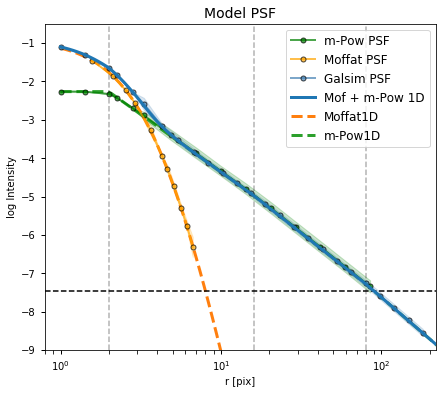

In [6]:
############################################
# Setup PSF
############################################

def Generate_PSF_mpow_Galsim(contrast, n_s=n_s, theta_s=theta_s, 
                             psf_scale=psf_pix_scale, psf_size=None,
                             min_psf_size=None, max_psf_size=None,
                             x_interpolant="linear", k_interpolant="linear"):
    """ theta_s in arcsec """
    if psf_size is None:
        a_psf = (theta_s[0]/psf_scale)**n_s[0]
        opt_psf_size = 2 * int((contrast * a_psf) ** (1./n_s[0]))
        opt_psf_size = round_good_fft(opt_psf_size)
        psf_size = max(min_psf_size, min(opt_psf_size, max_psf_size))

    cen_psf = ((psf_size-1)/2., (psf_size-1)/2.)
    yy_psf, xx_psf = np.mgrid[:psf_size, :psf_size]
    
    theta_s_psf_pix = theta_s / psf_scale
    psf_model =  multi_power2d(xx_psf, yy_psf, n_s, theta_s_psf_pix, 1, cen=cen_psf) 
    image_psf = galsim.ImageF(psf_model)
    
    psf_mpow = galsim.InterpolatedImage(image_psf, flux=1, scale=psf_scale,
                                        x_interpolant=x_interpolant, k_interpolant=k_interpolant)
    return psf_mpow, psf_size

# Define the Power PSF profile, one for making truth in galsim, one for display.
psf_mpow_1, psf_size_1 = Generate_PSF_mpow_Galsim(contrast=1e5, n_s=n_s, theta_s=theta_s,
                                                  psf_size=image_size, 
                                                  psf_scale=psf_pix_scale)
psf_mpow_2, psf_size_2 = Generate_PSF_mpow_Galsim(contrast=5e5, n_s=n_s, theta_s=theta_s,
                                                  psf_size=image_size*2, 
                                                  psf_scale=psf_pix_scale)

# Define the Moffat PSF profile.
gsparams = galsim.GSParams(folding_threshold=1.e-10)
psf_mof = galsim.Moffat(beta=beta_psf, flux=1., fwhm=fwhm, gsparams=gsparams) # in arcsec

if draw:
    star_psf_2 = (1-frac) * psf_mof + frac * psf_mpow_2
    
    img_mpow_2 = psf_mpow_2.drawImage(nx=201, ny=201, scale=pix_scale, method="no_pixel").array
    img_mof = psf_mof.drawImage(scale=pix_scale, method="no_pixel").array
    img_gs_2 = star_psf_2.drawImage(nx=image_size, ny=image_size, scale=pix_scale, method="no_pixel").array
    
    plt.figure(figsize=(7,6))

    r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(frac*img_mpow_2, pix_scale=pix_scale, seeing=2.5, 
                                                  core_undersample=True, color="g",
                                                  xunit="pix", yunit="intensity", label="m-Pow PSF")
    r_rbin, z_rbin, logzerr_rbin = cal_profile_1d((1-frac)*img_mof, pix_scale=pix_scale, seeing=2.5, 
                                                  core_undersample=True, color="orange",
                                                  xunit="pix", yunit="intensity", label="Moffat PSF")
    r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(img_gs_2, pix_scale=pix_scale, seeing=2.5,  
                                                  core_undersample=True, 
                                                  xunit="pix", yunit="intensity", label="Galsim PSF")

    r = np.logspace(0, np.log10(image_size), 100)
    
    c_mof2Dto1D = C_mof2Dto1D(gamma_pix, beta_psf)
    comp1 = moffat1d_normed(r, gamma=gamma_pix, alpha=beta_psf) / c_mof2Dto1D

    c_mpow2Dto1D = C_mpow2Dto1D(n_s, theta_s_pix)
    comp2 = multi_power1d_normed(r, n_s, theta_s_pix) / c_mpow2Dto1D
    
    
    plt.plot(r, np.log10((1-frac) * comp1 + comp2 * frac), ls="-", lw=3, label="Mof + m-Pow 1D",zorder=5)
    plt.plot(r, np.log10((1-frac) * comp1), ls="--", lw=3, label="Moffat1D",zorder=1)
    plt.plot(r, np.log10(comp2 * frac), ls="--",lw=3,  label="m-Pow1D")

    for theta in theta_s_pix:
        plt.axvline(theta, ls="--", color="k",alpha=0.3)
    plt.title("Model PSF",fontsize=14)
    plt.axhline(np.log10(comp1.max()/(Amps.max()/sigma*3)),color="k",ls="--")

    plt.legend(loc=1, fontsize=12)
    plt.ylim(-9, -0.5)

The above figure show the conversion between 1D profile (model) and 2D map is successful.

Generate noise background w/ stddev = 0.1.
Generate base image of faint stars (flux < 8e+04).
Total Time: 0.083s
Generate the truth image (faint stars with Moffat only).
Rendering bright stars in serial...
Total Time: 4.582s


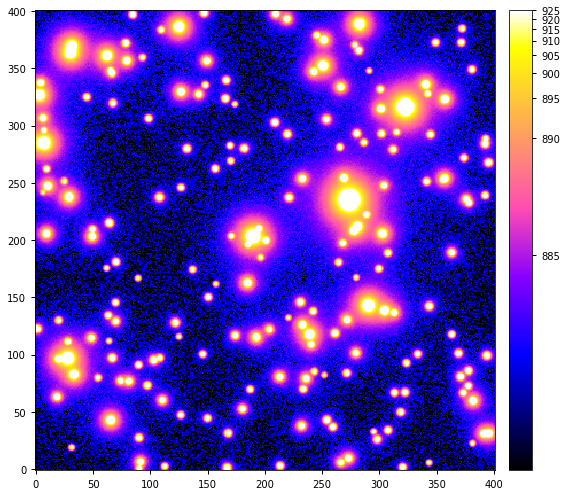

In [7]:
############################################
# Setup Image
############################################

print("Generate noise background w/ stddev = %.2g."%sigma)
noise_image = make_noise_image(image_size, noise_variance)

print("Generate base image of faint stars (flux < %.2g)."%(F_verybright))
image_gs0 = make_base_image(image_size, star_pos=star_pos[~bright], Flux=Flux[~bright], psf_base=psf_mof)

                   
# Make the truth image to be fitted (Moffat+power):
def make_truth_image(image_size, star_pos, Flux, noise, F_faint=5e2,
                     method="Real", parallel=parallel, saturation=4.5e4):
    
    """ Build Truth image with the position, flux and noise. 
    Two methods provided: 1) Galsim convolution in FFT and 2) Astropy model in real space. 
    [xx, yy, frac, bright, psf_mof, psf_pow is defined in the main.] """
    start = time.time()
    if method == "Galsim":
        full_image = galsim.ImageF(image_size, image_size)
                   
        for k, (pos, flux) in enumerate(zip(star_pos, Flux)): 

            if flux < F_faint:  # very faint stars, just assume truth is mofffat
                psf_star = psf_mof
            elif flux < F_verybright: 
                psf_star = (1-frac) * psf_mof + frac * psf_mpow_1
            else:
                psf_star = (1-frac) * psf_mof + frac * psf_mpow_2

            star = psf_star.withFlux(flux)
            (ix_nominal, iy_nominal), offset = get_center_offset(pos)

            stamp = star.drawImage(scale=pix_scale, offset=offset, method='no_pixel')
            stamp.setCenter(ix_nominal,iy_nominal)

            bounds = stamp.bounds & full_image.bounds
            full_image[bounds] += stamp[bounds]

        image_gs = full_image.array
        image = image_gs.copy()

    elif method == "Real":
        I_theta0_mpow = multi_power2d_Flux2Amp(n_s=n_s, theta_s=theta_s_pix, Flux=1)
        moffat2d_s = np.array([models.Moffat2D(amplitude=amp, x_0=x0, y_0=y0, gamma=gamma_pix, alpha=beta_psf) 
                      for (amp, (x0,y0)) in zip(Amps, star_pos)])
        multi_power2d_s = np.array([lambda xx, yy, cen=cen, flux=flux: \
                                    multi_power2d(xx, yy, cen=cen,
                                                  n_s=n_s, theta_s=theta_s_pix,
                                                  I_theta0=I_theta0_mpow*frac*flux)
                              for (flux, cen) in zip(Flux, star_pos)])
  
        # Draw stars in real space
        if not parallel:
            print("Rendering bright stars in serial...")
            image_real = np.sum([m2d(xx,yy) + p2d(xx,yy) 
                                 for (m2d,p2d) in zip(moffat2d_s[Flux>F_faint], 
                                                      multi_power2d_s[Flux>F_faint])], axis=0)
        else:
            print("Rendering bright stars in parallel...")
            func2d_s = np.concatenate([moffat2d_s[Flux>F_faint], multi_power2d_s[Flux>F_faint]])
            
            image_star_s = parallel_compute(func2d_s, p_map2d, lengthy_computation=False, verbose=True)
            image_real = np.sum(image_star_s, axis=0)
            
        image = image_real.copy()
        image += image_gs0  # add faint star base
        
    image += mu + noise # add background and noise
#     image[image>saturation] = saturation
        
    end = time.time()
    print("Total Time: %.3fs"%(end-start))
    
    return image

print("Generate the truth image (faint stars with Moffat only).")
image = make_truth_image(image_size, star_pos=star_pos, Flux=Flux, 
                         noise=noise_image, parallel=False, method="Real")

if draw:
    plt.figure(figsize=(8,7))
    im = plt.imshow(image, vmin=mu, vmax=925, norm=norm1, origin="lower", cmap="gnuplot2")
    colorbar(im)
    plt.tight_layout()


Mask inner regions of stars in dual mode:  S/N < 2 / r < 20 pix 
Use sky strips crossing very bright stars


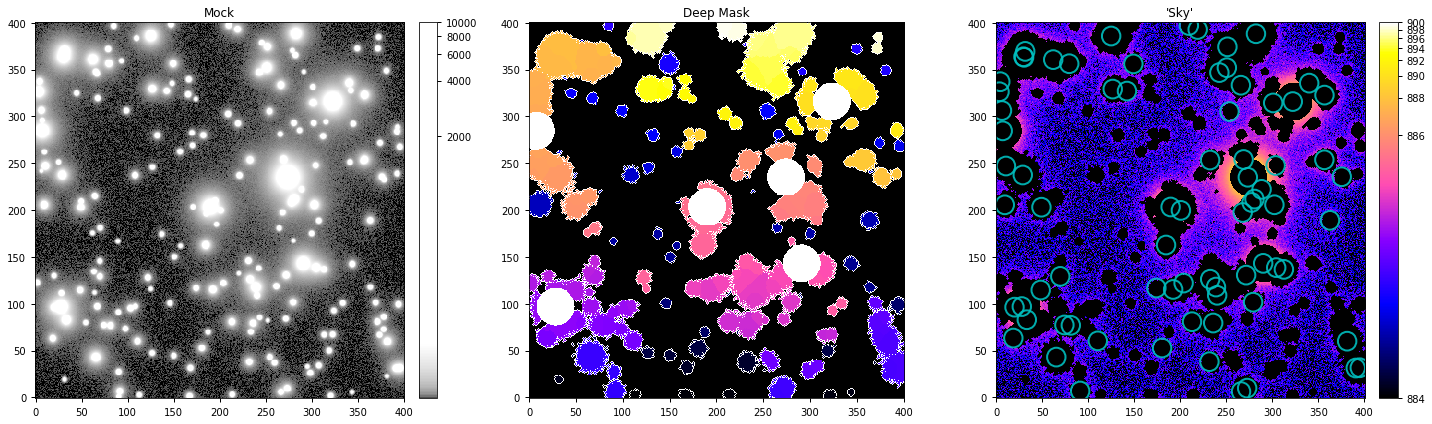

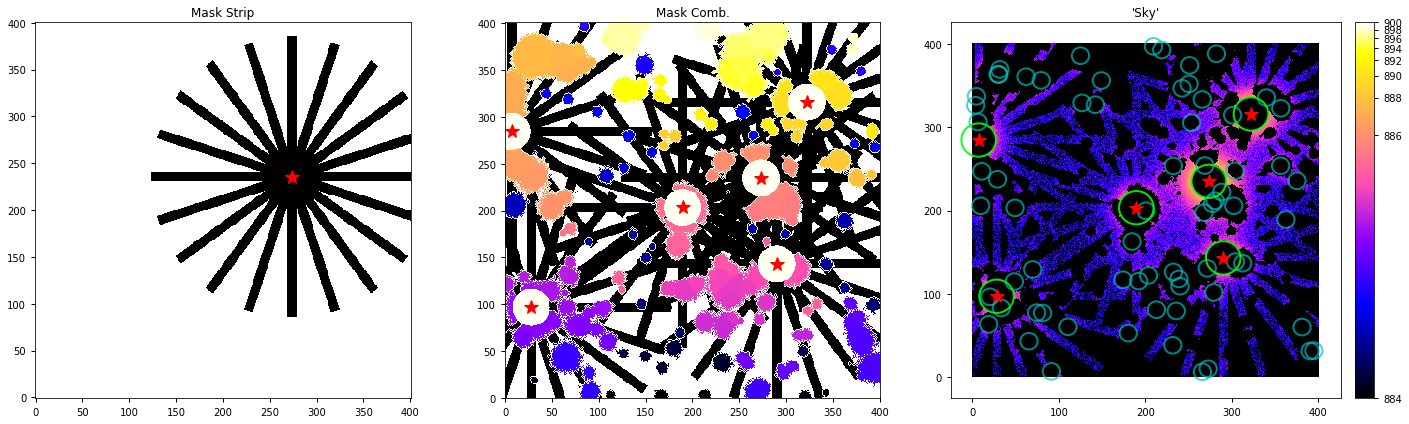

In [8]:
############################################
# Make Mask
############################################

# Make mask map for fitting
if mask_dual:
    print("Mask inner regions of stars in dual mode:  S/N < 2 / r < 20 pix ")
#         r_in_s = np.array([12 if F < F_verybright else 20 for F in Flux[bright]])
    mask_deep, seg_map, core_region = make_mask_map_dual(image, star_pos[verybright], 
                                                         r_in=20, nlevels=128, contrast=0.0001,
                                                         sn_thre=2, b_size=25, npix=4, n_dilation=1)
else:
    print("Mask inner regions of stars (threshold: S/N = 2.5)")
    mask_deep, seg_map = make_mask_map(image, sn_thre=2.5, b_size=25, npix=4, n_dilation=1)

if draw:
    fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, nrows=1, figsize=(20,6))
    im1 = ax1.imshow(image, origin='lower', cmap='gray', norm=norm1, vmin=mu, vmax=1e4, aspect='auto')
    ax1.set_title("Mock")
    colorbar(im1)

    ax2.imshow(seg_map, origin="lower", cmap="gnuplot2")
    ax2.set_title("Deep Mask")

    image2 = image.copy()
    image2[mask_deep] = 0
    im3 = ax3.imshow(image2, cmap='gnuplot2', norm=norm2, vmin=mu, vmax=900, origin='lower', aspect='auto') 
    ax3.set_title("'Sky'")
    colorbar(im3)

    aper = CircularAperture(star_pos[bright], r=10)
    aper.plot(color='c',lw=2,label="",alpha=0.9, axes=ax3)

    plt.tight_layout()

if mask_strip:
    print("Use sky strips crossing very bright stars")
    mask_strip_s = make_mask_strip(image_size, star_pos[verybright], Flux[verybright], 
                                   width=wid_strip, n_strip=n_strip, dist_strip=150)
    mask_strip_all = ~np.logical_or.reduce(mask_strip_s)
    seg_comb = seg_map.copy()
    seg_comb[mask_strip_all&(seg_map==0)] = seg_map.max()+1
    mask_comb = (seg_comb!=0)

    if draw:
        fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, nrows=1, figsize=(20,6))
        ax1.imshow(mask_strip_s[-1], origin="lower", cmap="gray_r")
        ax1.plot(star_pos[Flux.argsort()][-1][0], star_pos[Flux.argsort()][-1][1], "r*",ms=15)
        ax1.set_title("Mask Strip")

        ax2.imshow(seg_comb, origin="lower", cmap="gnuplot2")
        ax2.plot(star_pos[verybright][:,0], star_pos[verybright][:,1], "r*",ms=15)
        ax2.set_xlim(0,image_size)
        ax2.set_ylim(0,image_size)
        ax2.set_title("Mask Comb.")

        image3 = image.copy()
        image3[mask_comb] = 0
        im3 = ax3.imshow(image3, cmap='gnuplot2', norm=norm1, aspect='auto', vmin=mu, vmax=900, origin='lower') 
        ax3.plot(star_pos[verybright][:,0], star_pos[verybright][:,1], "r*",ms=15)
        ax3.set_xlim(-25,image_size+25)
        ax3.set_ylim(-25,image_size+25)
        ax3.set_title("'Sky'")
        colorbar(im3)
        
        aper = CircularAperture(star_pos[medbright], r=10)
        aper.plot(color='c',lw=2,label="",alpha=0.7, axes=ax3)
        aper = CircularAperture(star_pos[verybright], r=20)
        aper.plot(color='lime',lw=2,label="",alpha=0.9, axes=ax3)

        plt.tight_layout()


Test of generating mock images...
Done! Total Time: 0.596s



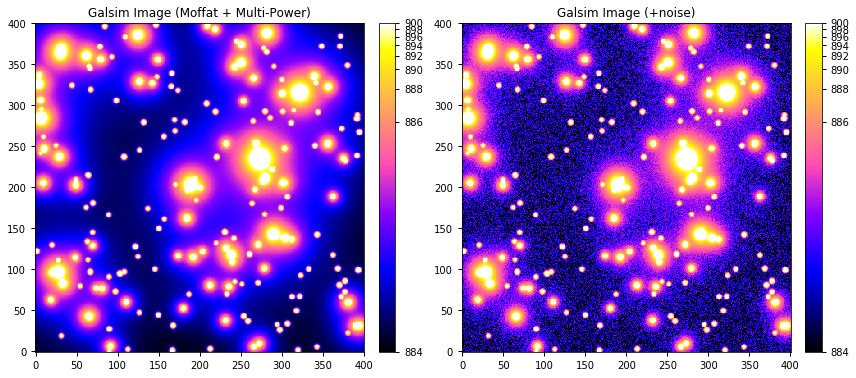

In [9]:
def generate_image_galsim(frac, n_s, theta_s, mu,
                          image_size=image_size,
                          min_psf_size=32, 
                          max_psf_size=256,
                          parallel=False, verbose=False):
    psf_mpow, psf_size = Generate_PSF_mpow_Galsim(contrast=1e5, n_s=n_s, theta_s=theta_s,
                                                  psf_scale=pix_scale, psf_size=None,  
                                                  min_psf_size=min_psf_size, max_psf_size=max_psf_size,
                                                  x_interpolant="linear", k_interpolant="linear")    
    # Setup the canvas
    full_image = galsim.ImageF(image_size, image_size)
    
    # Draw medium bright stars with galsim in Fourier space
    psf_star = (1-frac) * psf_mof + frac * psf_mpow               
    
    if not parallel:
        # Draw in serial
        for k in range(num_medbright):
            draw_star(k, star_pos=star_pos[medbright], Flux=Flux[medbright],
                      psf_star=psf_star, psf_size=psf_size,
                      full_image=full_image)
    else:
        # Draw in parallel, automatically back to serial computing if too few jobs 
        p_get_stamp_bounds = partial(get_stamp_bounds,
                                     star_pos=star_pos[medbright],
                                     Flux=Flux[medbright],
                                     psf_star=psf_star,
                                     psf_size=psf_size,
                                     full_image=full_image)
        
        results = parallel_compute(np.arange(num_medbright), p_get_stamp_bounds, 
                                   lengthy_computation=False, verbose=verbose)

        for (stamp, bounds) in results:
            full_image[bounds] += stamp[bounds]
            
#     if (n_s[0] < 2.5) | (image_size<500):
#         draw_real = True
#     else: 
    draw_real = False
        
    if draw_real:
        theta_s_pix = np.array(theta_s) / pix_scale
        # Draw very bright star (if highter cost in FFT) in real space
        image_gs = full_image.array
        I_theta0_mpow = multi_power2d_Flux2Amp(n_s=n_s, theta_s=theta_s_pix, Flux=1)
        for (pos, flux) in zip(star_pos[verybright], Flux[verybright]):
            p2d_vb = multi_power2d(xx, yy, cen=(pos[0],pos[1]),
                                   n_s=n_s, theta_s=theta_s_pix, 
                                   I_theta0=I_theta0_mpow*frac*flux)
            image_gs += p2d_vb
    else:
        # Draw very bright star in Fourier space 
        psf_mpow_vb , psf_size = Generate_PSF_mpow_Galsim(contrast=5e6, n_s=n_s, theta_s=theta_s,
                                                         psf_scale=pix_scale, psf_size=None,  
                                                         min_psf_size=2*min_psf_size, max_psf_size=2*max_psf_size,
                                                         x_interpolant="linear", k_interpolant="linear")
        psf_star = (1-frac) * psf_mof + frac * psf_mpow_vb 
                              
        for k in range(num_verybright):
            draw_star(k, star_pos=star_pos[verybright], Flux=Flux[verybright],
                      psf_star=psf_star, psf_size=psf_size, full_image=full_image)
            
        image_gs = full_image.array
                   
    image = image_gs.copy() + image_gs0 + mu # add the faint star base and background

    return image

if draw:
    start = time.time()
    print("Test of generating mock images...")
    image_tri = generate_image_galsim(frac=frac, n_s=n_s, theta_s=theta_s,  
                                      mu=mu, parallel=False, verbose=True)
    end = time.time()
    print("Done! Total Time: %.3fs\n"%(end-start))

    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))
    im = ax1.imshow(image_tri, vmin=mu, vmax=900, norm=norm1, origin="lower", cmap="gnuplot2")
    colorbar(im)
    im = ax2.imshow(image_tri + noise_image, vmin=mu, vmax=900, norm=norm1, origin="lower", cmap="gnuplot2")
    ax1.set_title("Galsim Image (Moffat + Multi-Power)")
    ax2.set_title("Galsim Image (+noise)")
    colorbar(im)
    plt.tight_layout()   

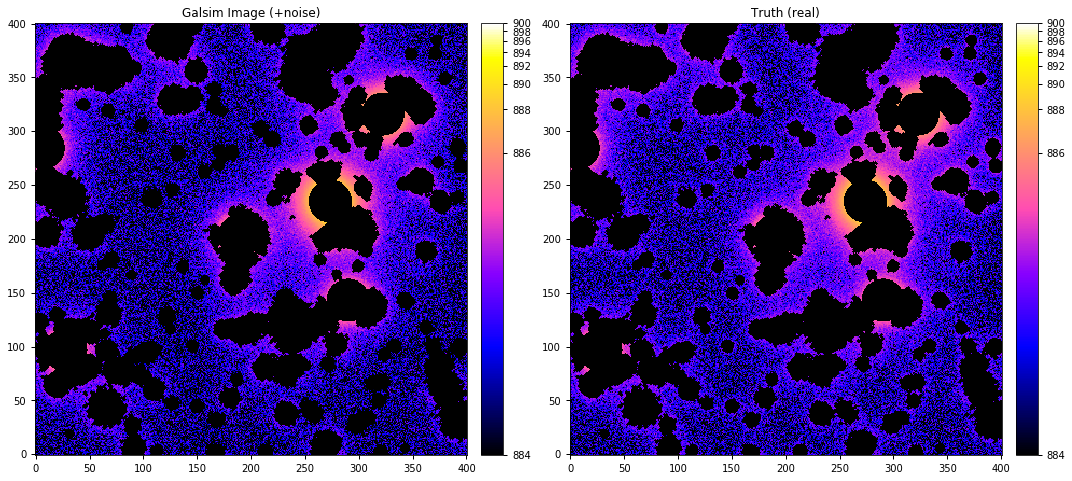

In [10]:
fig, (ax2, ax3) = plt.subplots(1,2,figsize=(15,7))
image_tri2 = image_tri + noise_image
image_tri2[mask_deep]  = 0
im = ax2.imshow(image_tri2, vmin=mu, vmax=900, norm=norm1, origin="lower", cmap="gnuplot2")    
ax2.set_title("Galsim Image (+noise)")
colorbar(im)

im = ax3.imshow(image2, vmin=mu, vmax=900, norm=norm1, origin="lower", cmap="gnuplot2")
ax3.set_title("Truth (real)")
colorbar(im)
plt.tight_layout()   

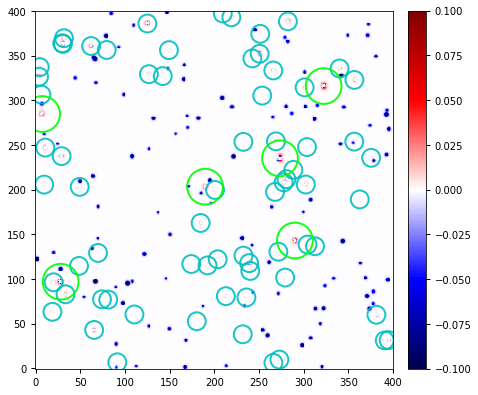

In [11]:
plt.figure(figsize=(7,7))
ax=plt.subplot(111)
im = plt.imshow((image_tri-image)/image, vmin=-0.1, vmax=0.1, origin="lower", cmap="seismic")
colorbar(im)
aper = CircularAperture(star_pos[medbright], r=10)
aper.plot(color='c',lw=2,alpha=0.9,axes=ax)
aper = CircularAperture(star_pos[verybright], r=20)
aper.plot(color='lime',lw=2,alpha=0.9,axes=ax)

In [13]:
# # Priors and Likelihood Models for Fitting
############################################

import dynesty
import time
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
import multiprocess as mp

if mask_strip is True:
    mask_fit = mask_comb
else:
    mask_fit = mask_deep
    
truths = np.concatenate([n_s, [mu, sigma]])
labels = [r'$n%d$'%i for i in range(len(n_s))] + [r'$\mu$', r'$\sigma$']
# labels = [r'$n0$', r'$n1$', r'$\theta_1$', r'$\mu$', r'$\sigma$']

print("Truths: ", np.around(truths, 3))
print("Labels: ", labels)

mu_patch, std_patch = np.median(image[~mask_fit]), mad_std(image[~mask_fit])
print("Estimate of Background: (%.3f, %.3f)"%(mu_patch, std_patch))


def prior_tf_mp(u):
    v = u.copy()
    v[0] = u[0] * 2.8 + 0.4  # n0
    for k in range(len(u)-3):
        v[k+1] = 1. * u[k+1] - 0.5 + v[k]  # n_{k+1} : [n_k-0.5, n_k+0.5]
#     v[3] = u[3] + 1  # log theta1 : 1-2
#     v[4] = stats.uniform.ppf(u[4], loc=v[3], scale=2.5-v[3])  # log theta2 : log theta1-2.5
    v[-2] = stats.truncnorm.ppf(u[-2], a=-2, b=0.1, loc=mu_patch, scale=std_patch)  # mu
    v[-1] = stats.truncnorm.ppf(u[-1], a=-1, b=0.1, loc=std_patch, scale=0.1)    # sigma 
    return v
        
def prior_tf_2p(u):
    v = u.copy()
    v[0] = u[0] * 0.6 + 3.2  # n0 : 3.2-3.8
    v[1] = u[1] * 2 + 5  # n1 : 2-5
    v[2] = u[2] + 1.7  # log theta1 : 50-200
    v[-2] = 888 - stats.rayleigh.ppf(u[-2], loc=0, scale=3.)  # mu
    v[-1] = stats.norm.ppf(u[-1], loc=0.1, scale=0.02)  # sigma : N(1, 0.02)
    return v
    
    
X = np.array([xx,yy])
Y = image[~mask_fit].copy().ravel()

def loglike_mp(v):
    n_s = v[:-2]
    mu, sigma = v[-2:]
    
    image_tri = generate_image_galsim(frac=frac, n_s=n_s, theta_s=theta_s, 
                                      mu=mu, parallel=False)
    
    ypred = image_tri[~mask_fit].ravel()
    residsq = (ypred - Y)**2 / sigma**2
    loglike = -0.5 * np.sum(residsq + np.log(2 * np.pi * sigma**2))
    
    if not np.isfinite(loglike):
        loglike = -1e100
        
    return loglike

def loglike_2p(v):
    n_s = v[:2]
    theta_s = np.array([theta_0, v[2]])
    mu, sigma = v[-2:]
    
    image_tri = generate_image_galsim(frac=frac, n_s=n_s, theta_s=theta_s, 
                                      mu=mu, parallel=True)
    
    ypred = image_tri[~mask_fit].ravel()
    residsq = (ypred - Y)**2 / sigma**2
    loglike = -0.5 * np.sum(residsq + np.log(2 * np.pi * sigma**2))
    
    if not np.isfinite(loglike):
        loglike = -1e100
        
    return loglike

def Run_Nested_Fitting(loglike, 
                       prior_transform, 
                       ndim=len(labels),
                       nlive_init=200, nlive_batch=50, maxbatch=2,
                       print_progress=True):
    print("Run Nested Fitting for the image... Dim of paramas: %d"%ndim)    
    with mp.Pool(processes=n_cpu) as pool:
        print("Opening pool: # of CPU used: %d"%(n_cpu))
        pool.size = n_cpu

        dlogz = 1e-3 * (nlive_init - 1) + 0.01

        pdsampler = dynesty.DynamicNestedSampler(loglike, prior_transform, ndim,
                                                 pool=pool, use_pool={'update_bound': False})
        pdsampler.run_nested(nlive_init=nlive_init, 
                             nlive_batch=nlive_batch, 
                             maxbatch=maxbatch,
                             print_progress=True, 
                             dlogz_init=dlogz, 
                             wt_kwargs={'pfrac': 0.8})
    return pdsampler

Truths:  [3.00e+00 3.30e+00 3.60e+00 8.84e+02 1.00e-01]
Labels:  ['$n0$', '$n1$', '$n2$', '$\\mu$', '$\\sigma$']
Estimate of Background: (884.138, 0.156)


Run Nested Fitting for the image... Dim of paramas: 5
Opening pool: # of CPU used: 3


iter: 2871 | batch: 2 | bound: 55 | nc: 1 | ncall: 11526 | eff(%): 24.909 | loglstar: 49238.346 < 49242.390 < 49240.303 | logz: 49220.287 +/-  0.633 | stop:  4.474                                   


Finish Fitting! Total time elapsed: 3.48e+03s


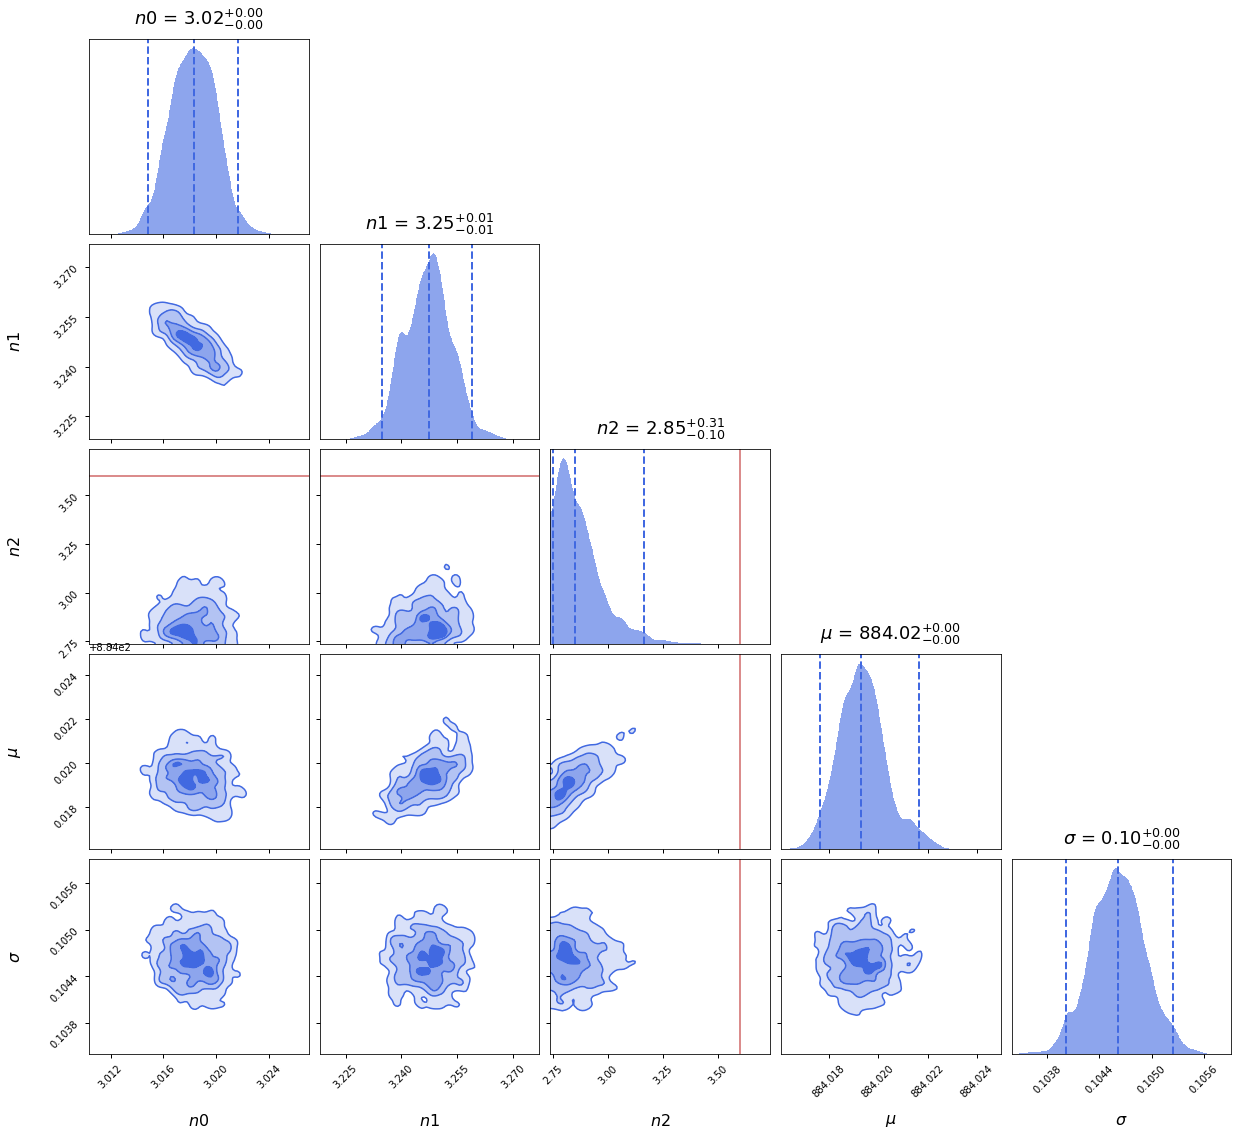

In [15]:
############################################
# Fitting
############################################

if RUN_FITTING:
    start = time.time()
    pdsampler = Run_Nested_Fitting(loglike=loglike_mp, prior_transform=prior_tf_mp, nlive_init=100)
    end = time.time()
    print("Finish Fitting! Total time elapsed: %.3gs"%(end-start))
    
    pdres = pdsampler.results

    # Plot Result
    fig, axes = dyplot.cornerplot(pdres, truths=truths, show_titles=True, 
                                  color="royalblue", truth_color="indianred",
                                  title_kwargs={'fontsize':18, 'y': 1.04}, labels=labels,
                                  label_kwargs={'fontsize':16},
                                  fig=plt.subplots(len(labels), len(labels), figsize=(18, 16)))

Fitting (mean):  [3.01827202e+00 3.24714094e+00 2.87331714e+00 8.84019376e+02
 1.04613626e-01]
Fitting (median):  [3.01828384e+00 3.24746847e+00 2.84783718e+00 8.84019309e+02
 1.04612178e-01]


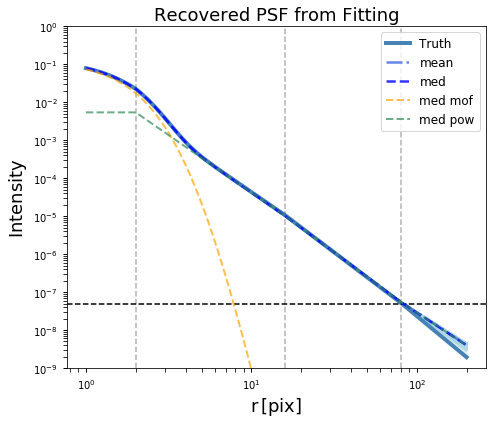

In [21]:
true_pars = {"gamma":gamma_pix, "alpha":beta_psf, "frac":frac}
for i in range(len(n_s)):
    true_pars["n%d"%i] = n_s[i]

plot_fitting_vs_truth_PSF_mpow(pdres, n_bootstrap=1000, image_size=image_size, save=False, true_pars = true_pars)

In [47]:
if RUN_FITTING:
    start = time.time()
    pdsampler = Run_Nested_Fitting(loglike=loglike_2p, prior_transform=prior_tf_2p)
    end = time.time()
    print("Finish Fitting! Total time elapsed: %.3gs"%(end-start))
    
    pdres = pdsampler.results

    # Plot Result
    fig, axes = dyplot.cornerplot(pdres, truths=truths, show_titles=True, 
                                  color="royalblue", truth_color="indianred",
                                  title_kwargs={'fontsize':18, 'y': 1.04}, labels=labels,
                                  label_kwargs={'fontsize':16},
                                  fig=plt.subplots(len(labels), len(labels), figsize=(18, 16)))


In [ ]:
true_pars = {"gamma":gamma_pix, "alpha":beta_psf, "frac":frac}
for i in range(len(n_s)):
    true_pars["n%d"%i] = n_s[i]

plot_fitting_vs_truth_PSF_mpow(pdres, n_bootstrap=400, image_size=image_size, save=False, true_pars = true_pars)

Opening pool: # of CPU used: 3


iter: 10593 | batch: 2 | bound: 218 | nc: 4 | ncall: 79601 | eff(%): 13.308 | loglstar: 71955.125 < 71960.041 < 71959.708 | logz: 71926.962 +/-  0.467 | stop:  3.624                                 


Finish Fitting! Total time elapsed: 2.06e+04s


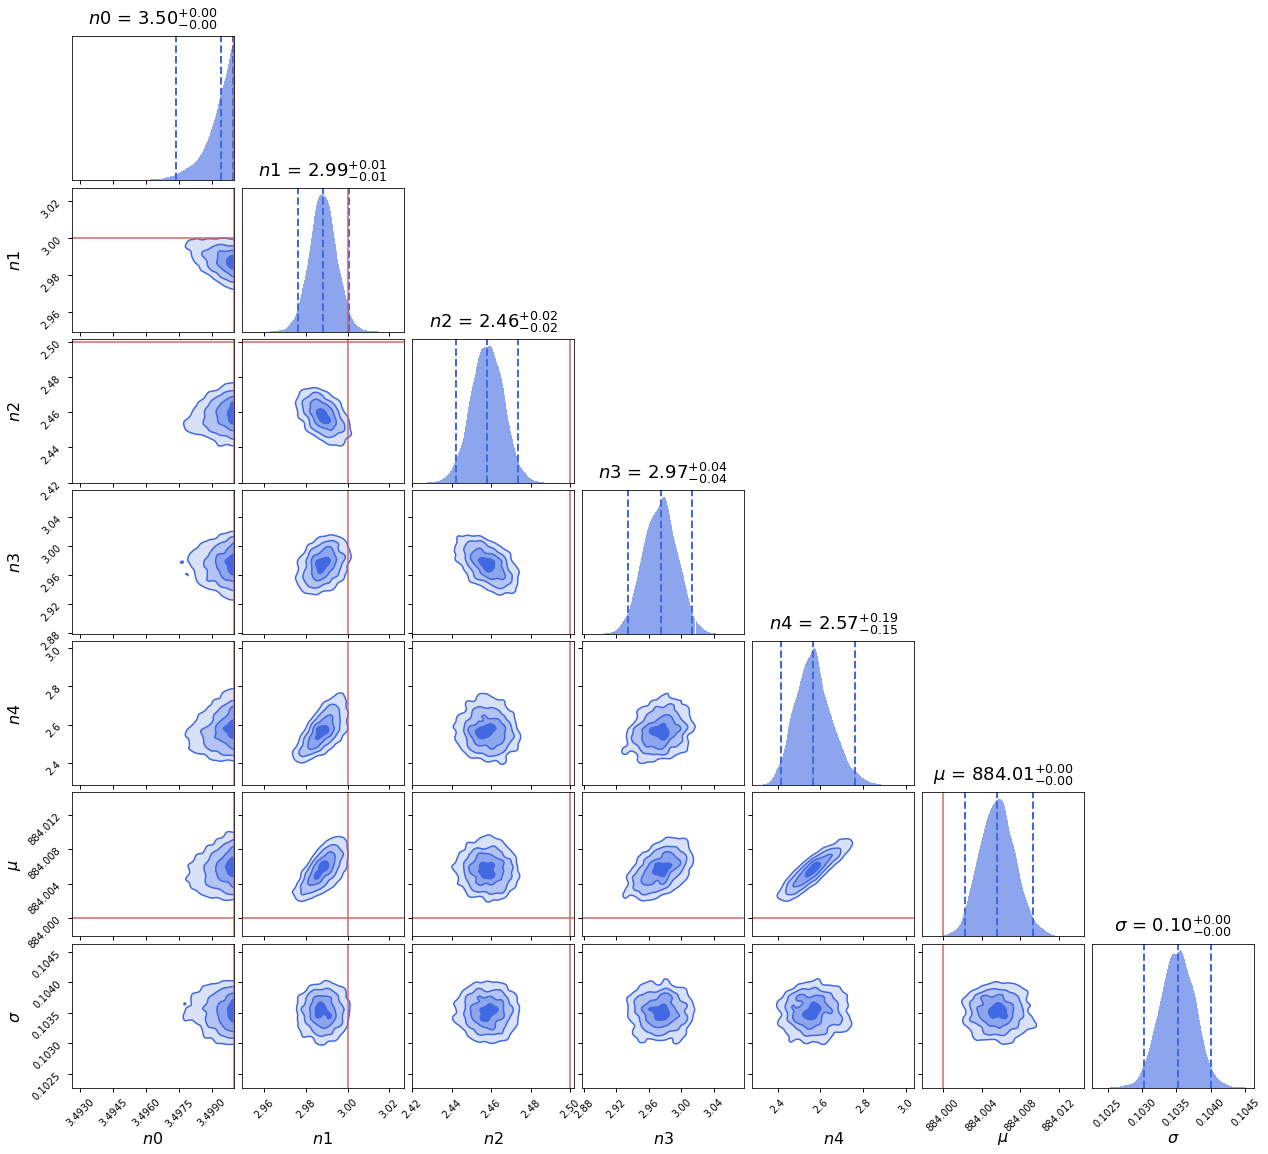

In [23]:
############################################
# Fitting
############################################

if RUN_FITTING:
    start = time.time()
    pdsampler = Run_Nested_Fitting(loglike, prior_transform, truths=truths)
    end = time.time()
    print("Finish Fitting! Total time elapsed: %.3gs"%(end-start))
    
    pdres = pdsampler.results

    # Plot Result
    fig, axes = dyplot.cornerplot(pdres, truths=truths, show_titles=True, 
                                  color="royalblue", truth_color="indianred",
                                  title_kwargs={'fontsize':18, 'y': 1.04}, labels=labels,
                                  label_kwargs={'fontsize':16},
                                  fig=plt.subplots(len(truths), len(truths), figsize=(18, 16)))
    if save:
        plt.savefig("%s/Result.png"%dir_name,dpi=150)
        plt.close('all')
                   

Fitting (mean):  [3.49922399e+00 2.98825536e+00 2.45802515e+00 2.97413690e+00
 2.56970600e+00 8.84005645e+02 1.03516762e-01]
Fitting (median):  [3.49941769e+00 2.98825706e+00 2.45810196e+00 2.97473312e+00
 2.56589336e+00 8.84005626e+02 1.03519278e-01]


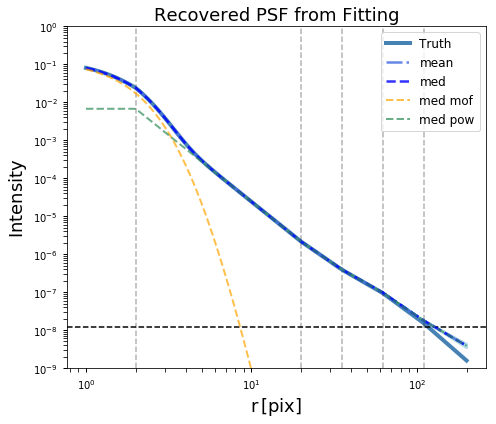

In [46]:
true_pars = {"gamma":gamma_pix, "alpha":beta_psf, "frac":frac}
for i in range(len(n_s)):
    true_pars["n%d"%i] = n_s[i]

plot_fitting_vs_truth_PSF_mpow(pdres, n_bootstrap=400, image_size=image_size, save=False, true_pars = true_pars)

In [18]:
def plot_fitting_vs_truth_PSF_mpow(res, true_pars, image_size=image_size, 
                                   n_bootstrap=200, save=False, dir_name="."):
    from dynesty import utils as dyfunc
    
    samples = res.samples                                 # samples
    weights = np.exp(res.logwt - res.logz[-1])            # normalized weights 
    pmean, pcov = dyfunc.mean_and_cov(samples, weights)     # weighted mean and covariance
    samples_eq = dyfunc.resample_equal(samples, weights)  # resample weighted samples
    pmed = np.median(samples_eq,axis=0)                    # median sample
    
    print("Fitting (mean): ", pmean)
    print("Fitting (median): ", pmed)
    
    from astropy.stats import bootstrap
    samples_eq_bs = bootstrap(samples_eq, bootnum=1, samples=n_bootstrap)[0]

    gamma, alpha, frac = true_pars["gamma"], true_pars["alpha"], true_pars["frac"]
    n_s = [true_pars["n%d"%i] for i in range(len(pmean)-2)]

    c_mof2Dto1D =  C_mof2Dto1D(gamma, beta_psf)
    c_mpow2Dto1D = C_mpow2Dto1D(n_s=n_s, theta_s=theta_s_pix)
    
    
    r = np.logspace(0., np.log10(image_size//2), 100)
    comp1 = moffat1d_normed(r, gamma=gamma, alpha=alpha) / c_mof2Dto1D
    comp2 = multi_power1d_normed(r, n_s=n_s, theta_s=theta_s_pix) / c_mpow2Dto1D
    
    plt.figure(figsize=(7,6))
    
    plt.semilogy(r, (1-frac) * comp1 + frac * comp2,
                 label="Truth", color="steelblue", lw=4, zorder=2)
    for n_s_k in samples_eq_bs[:,:-2]:
        comp2_k = multi_power1d_normed(r, n_s=n_s_k, theta_s=theta_s_pix) / c_mpow2Dto1D

        plt.semilogy(r, (1-frac) * comp1 + frac * comp2_k,
                     color="lightblue", lw=1.5,alpha=0.1,zorder=1)
    else:
        for fits, c, ls, l in zip([pmed, pmean], ["royalblue", "b"],
                                  ["-.","--"], ["mean", "med"]):
            
            n_s_fit = fits[:-2]  
            comp2 = multi_power1d_normed(r, n_s=n_s_fit, theta_s=theta_s_pix) / c_mpow2Dto1D
            y_fit = (1-frac) * comp1 + frac * comp2
            
            plt.semilogy(r, y_fit, color=c, lw=2.5, ls=ls, alpha=0.8, label=l, zorder=4)
            if l=="med":
                plt.semilogy(r, (1-frac) * comp1,
                             color="orange", lw=2, ls="--", alpha=0.7, label="med mof",zorder=4)
                plt.semilogy(r, frac * comp2,
                             color="seagreen", lw=2, ls="--", alpha=0.7, label="med pow",zorder=4)
    plt.axhline(img_gs_2.max()/(Amps.max()/sigma*3),color="k",ls="--")
    for theta in theta_s_pix:
        plt.axvline(theta, ls="--", color="k",alpha=0.3)
    plt.legend(loc=1, fontsize=12)    
    plt.xlabel(r"$\rm r\,[pix]$",fontsize=18)
    plt.ylabel(r"$\rm Intensity$",fontsize=18)
    plt.title("Recovered PSF from Fitting",fontsize=18)
    plt.xscale("log")
    plt.ylim(1e-9, 1)    
    plt.tight_layout()
    if save:
        plt.savefig("%s/Fit_PSF.png"%dir_name,dpi=150)
        plt.close()